In [1]:
import datetime

import eli5
import matplotlib.pyplot as plt
import missingno as msno
import numpy as np
import pandas as pd
import scipy.stats as stats
from eli5.sklearn import PermutationImportance
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import (GridSearchCV, RandomizedSearchCV,
                                     cross_val_score, train_test_split)
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import OneHotEncoder

## 1. Загрузка данных

In [2]:
df_hits = pd.read_csv('data/ga_hits.csv')
df_hits.head()

,session_id,hit_date,hit_time,hit_number,hit_type,hit_referer,hit_page_path,event_category,event_action,event_label,event_value
0,5639623078712724064.1640254056.1640254056,2021-12-23,597864.0,30,event,NaN,sberauto.com/cars?utm_source_initial=google&ut...,quiz,quiz_show,NaN,NaN
1,7750352294969115059.1640271109.1640271109,2021-12-23,597331.0,41,event,NaN,sberauto.com/cars/fiat?city=1&city=18&rental_c...,quiz,quiz_show,NaN,NaN
2,885342191847998240.1640235807.1640235807,2021-12-23,796252.0,49,event,NaN,sberauto.com/cars/all/volkswagen/polo/e994838f...,quiz,quiz_show,NaN,NaN
3,142526202120934167.1640211014.1640211014,2021-12-23,934292.0,46,event,NaN,sberauto.com/cars?utm_source_initial=yandex&ut...,quiz,quiz_show,NaN,NaN
4,3450086108837475701.1640265078.1640265078,2021-12-23,768741.0,79,event,NaN,sberauto.com/cars/all/mercedes-benz/cla-klasse...,quiz,quiz_show,NaN,NaN


In [3]:
df_sessions = pd.read_csv('data/ga_sessions.csv')
df_sessions.head()

C:\Users\Kirill\AppData\Local\Temp\ipykernel_25752\2811086100.py:1: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_sessions = pd.read_csv('data/ga_sessions.csv')


,session_id,client_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,utm_keyword,device_category,device_os,device_brand,device_model,device_screen_resolution,device_browser,geo_country,geo_city
0,9055434745589932991.1637753792.1637753792,2108382700.163776,2021-11-24,14:36:32,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,NaN,360x720,Chrome,Russia,Zlatoust
1,905544597018549464.1636867290.1636867290,210838531.163687,2021-11-14,08:21:30,1,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,xhoenQgDQsgfEPYNPwKO,IGUCNvHlhfHpROGclCit,mobile,Android,Samsung,NaN,385x854,Samsung Internet,Russia,Moscow
2,9055446045651783499.1640648526.1640648526,2108385331.164065,2021-12-28,02:42:06,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,NaN,360x720,Chrome,Russia,Krasnoyarsk
3,9055447046360770272.1622255328.1622255328,2108385564.162225,2021-05-29,05:00:00,1,kjsLglQLzykiRbcDiGcD,cpc,NaN,NOBKLgtuvqYWkXQHeYWM,NaN,mobile,NaN,Xiaomi,NaN,393x786,Chrome,Russia,Moscow
4,9055447046360770272.1622255345.1622255345,2108385564.162225,2021-05-29,05:00:00,2,kjsLglQLzykiRbcDiGcD,cpc,NaN,NaN,NaN,mobile,NaN,Xiaomi,NaN,393x786,Chrome,Russia,Moscow


## 2. Data preparation

In [4]:
df_hits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15726470 entries, 0 to 15726469
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   session_id      object 
 1   hit_date        object 
 2   hit_time        float64
 3   hit_number      int64  
 4   hit_type        object 
 5   hit_referer     object 
 6   hit_page_path   object 
 7   event_category  object 
 8   event_action    object 
 9   event_label     object 
 10  event_value     float64
dtypes: float64(2), int64(1), object(8)
memory usage: 1.3+ GB


In [5]:
df_hits.duplicated().sum()

0

In [6]:
df_sessions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1860042 entries, 0 to 1860041
Data columns (total 18 columns):
 #   Column                    Dtype 
---  ------                    ----- 
 0   session_id                object
 1   client_id                 object
 2   visit_date                object
 3   visit_time                object
 4   visit_number              int64 
 5   utm_source                object
 6   utm_medium                object
 7   utm_campaign              object
 8   utm_adcontent             object
 9   utm_keyword               object
 10  device_category           object
 11  device_os                 object
 12  device_brand              object
 13  device_model              object
 14  device_screen_resolution  object
 15  device_browser            object
 16  geo_country               object
 17  geo_city                  object
dtypes: int64(1), object(17)
memory usage: 255.4+ MB


In [7]:
df_sessions.duplicated().sum()

0

<Axes: >

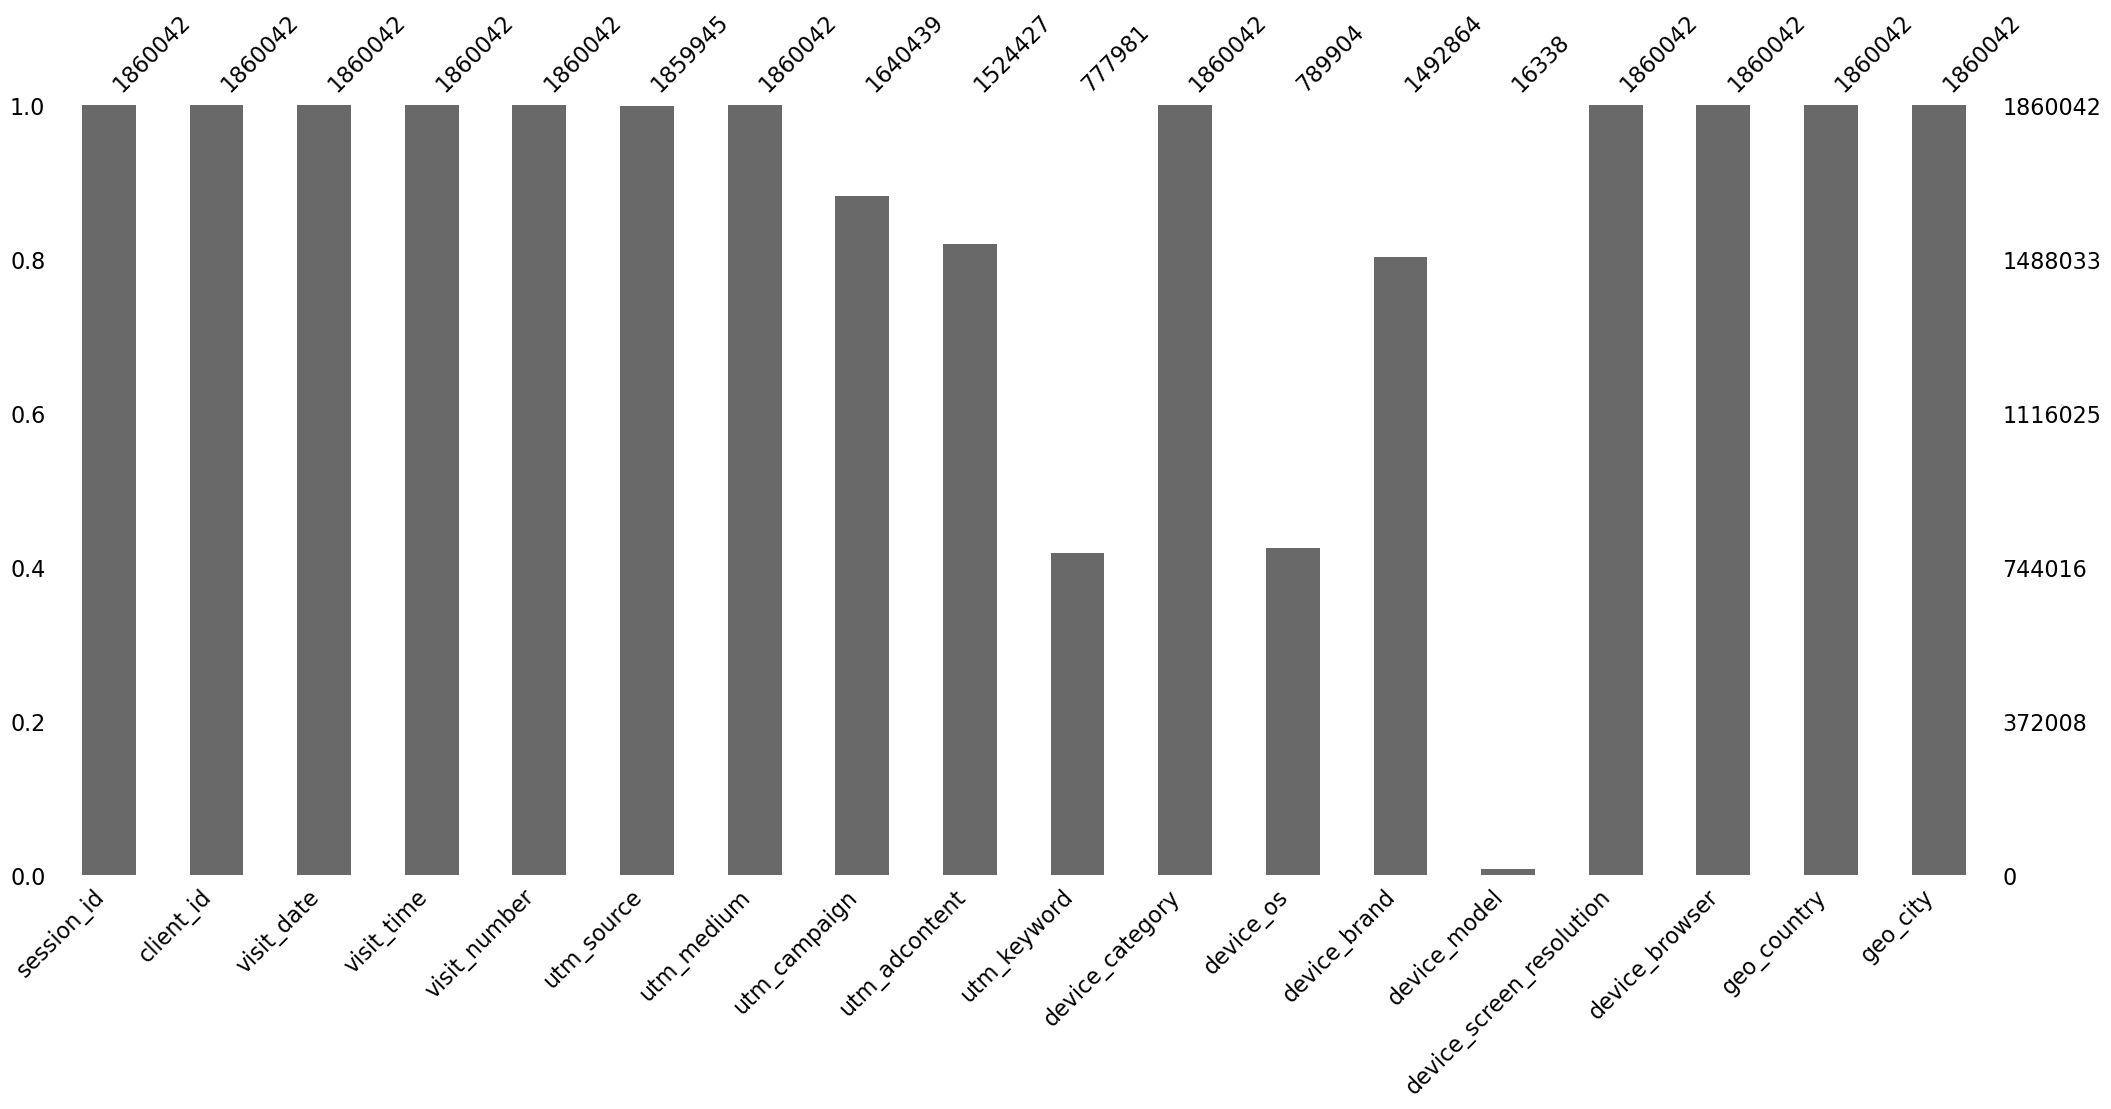

In [8]:
msno.bar(df_sessions)

### Рассмотрим фичи связанные с посещением

In [9]:
df_sessions[['visit_date', 'visit_time', 'visit_number']]

,visit_date,visit_time,visit_number
0,2021-11-24,14:36:32,1
1,2021-11-14,08:21:30,1
2,2021-12-28,02:42:06,1
3,2021-05-29,05:00:00,1
4,2021-05-29,05:00:00,2
...,...,...,...
1860037,2021-12-22,10:48:25,1
1860038,2021-05-26,08:00:00,1
1860039,2021-11-15,15:31:55,1
1860040,2021-11-29,15:36:44,1


{'whiskers': [<matplotlib.lines.Line2D at 0x176756f06d0>,
 'caps': [<matplotlib.lines.Line2D at 0x176756f0c10>,
 'boxes': [<matplotlib.lines.Line2D at 0x176756f0430>],
 'medians': [<matplotlib.lines.Line2D at 0x176756f1150>],
 'fliers': [<matplotlib.lines.Line2D at 0x176756f13f0>],
 'means': []}

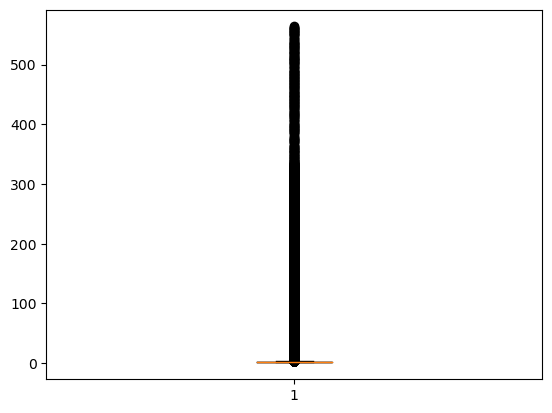

In [10]:
plt.boxplot(df_sessions.visit_number)

В результате построения ящика с усами можно увидеть много выбросов, но их удалять не будем т.к. выполнение целевого действия может зависеть от кол-ва посещений.

### Рассмотрим фичи связанные с рекламой

Из данных фичей рассмотрим utm_source, utm_medium, utm_campaign (канал привлечения, тип привлечения, рекламная кампания)

In [11]:
df_sessions[['utm_source', 'utm_medium', 'utm_campaign']]

,utm_source,utm_medium,utm_campaign
0,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd
1,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV
2,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd
3,kjsLglQLzykiRbcDiGcD,cpc,NaN
4,kjsLglQLzykiRbcDiGcD,cpc,NaN
...,...,...,...
1860037,BHcvLfOaCWvWTykYqHVe,cpc,NaN
1860038,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg
1860039,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg
1860040,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd


In [12]:
df_sessions.utm_source.describe()

count                  1859945
unique                     293
top       ZpYIoDJMcFzVoPFsHGJL
freq                    578290
Name: utm_source, dtype: object

In [13]:
df_sessions.utm_medium.describe()

count     1860042
unique         56
top        banner
freq       552272
Name: utm_medium, dtype: object

In [14]:
df_sessions.utm_campaign.describe()

count                  1640439
unique                     412
top       LTuZkdKfxRGVceoWkVyg
freq                    463481
Name: utm_campaign, dtype: object

Составим датафрейм из этих фичей и удалим пропущенные значения, затем с помощью метрики V Крамера посмотрим на корреляцию

In [15]:
utm_df = df_sessions[['utm_source', 'utm_medium', 'utm_campaign']].dropna()

In [16]:
def cramers_v(confusion_matrix):
    chi2 = stats.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    min_dim = min(confusion_matrix.shape) - 1
    return np.sqrt(chi2 / (n * min_dim))

In [17]:
contingency_table_c_m = pd.crosstab(utm_df['utm_campaign'], utm_df['utm_medium'])

In [18]:
cramers_v(contingency_table_c_m) # между реламной компанией и типом привлечения наблюдается сильная корреляция

0.7784432138939925

In [19]:
contingency_table_s_m = pd.crosstab(utm_df['utm_source'], utm_df['utm_medium'])

In [20]:
cramers_v(contingency_table_s_m) # между каналом привлечения и типом привлечения наблюдается сильная корреляция

0.7095149211388

При такой корреляции, в дальнейшем оставим только тип привлечения в качестве фичи

In [21]:
df_sessions.utm_medium.value_counts()

utm_medium
banner               552272
cpc                  434794
(none)               300575
cpm                  242083
referral             152050
organic               63034
email                 29240
push                  28035
stories               10582
cpv                    8022
blogger_channel        8015
smartbanner            6794
blogger_stories        4312
cpa                    4279
tg                     4011
app                    2836
post                   2326
smm                    1985
outlook                1332
clicks                  934
blogger_header          771
(not set)               480
info_text               343
sms                     239
landing                 134
partner                  97
fb_smm                   66
vk_smm                   65
link                     57
cbaafe                   47
CPM                      40
yandex_cpc               36
ok_smm                   28
static                   22
google_cpc               20
article  

В значениях присутствуют значения неопределенные категории (none) и (not set), которые являются одним и тем же значением. Заменим (none) на (not set)

In [22]:
df_sessions.utm_medium = df_sessions.utm_medium.replace('(none)', '(not set)')

### Рассмотрим фичи связанные с устройством

In [23]:
df_sessions[['device_category', 'device_os', 'device_brand', 'device_model', 'device_screen_resolution', 'device_browser']]

,device_category,device_os,device_brand,device_model,device_screen_resolution,device_browser
0,mobile,Android,Huawei,NaN,360x720,Chrome
1,mobile,Android,Samsung,NaN,385x854,Samsung Internet
2,mobile,Android,Huawei,NaN,360x720,Chrome
3,mobile,NaN,Xiaomi,NaN,393x786,Chrome
4,mobile,NaN,Xiaomi,NaN,393x786,Chrome
...,...,...,...,...,...,...
1860037,desktop,Windows,NaN,NaN,1920x1080,Chrome
1860038,mobile,NaN,Apple,NaN,390x844,Safari
1860039,mobile,iOS,Apple,NaN,375x667,Safari
1860040,mobile,Android,Xiaomi,NaN,393x851,Chrome


In [24]:
contingency_table_sr_c = pd.crosstab(df_sessions['device_screen_resolution'], df_sessions['device_category'])

In [25]:
cramers_v(contingency_table_sr_c) # между разрешением экрана и категорией устройства наблюдается сильная корреляция

0.8686995308099211

Среди представленных фичей оставим только разрешение экрана (device_screen_resolution). Остальные либо содержат много пропусков, либо не представляют уникальную информацию.

### Рассмотрим фичи связанные с местоположение

In [26]:
df_sessions[['geo_country', 'geo_city']]

,geo_country,geo_city
0,Russia,Zlatoust
1,Russia,Moscow
2,Russia,Krasnoyarsk
3,Russia,Moscow
4,Russia,Moscow
...,...,...
1860037,Russia,Moscow
1860038,Russia,Stavropol
1860039,Russia,Moscow
1860040,Russia,Chelyabinsk


In [27]:
df_sessions.geo_country.value_counts()

geo_country
Russia                 1800565
United States            11784
Ukraine                   9012
Ireland                   4034
Belarus                   3636
                        ...   
Zambia                       1
Malawi                       1
Réunion                      1
Barbados                     1
Congo - Brazzaville          1
Name: count, Length: 166, dtype: int64

In [28]:
df_sessions.loc[df_sessions.geo_country != 'Russia', 'geo_country'] = 'Other' # Заменим все названия иностранных стран на Other

In [29]:
df_sessions.geo_country.value_counts()

geo_country
Russia    1800565
Other       59477
Name: count, dtype: int64

Большинство значений равно Russia, поэтому в дальнейшем будем рассматривать только два значения

In [30]:
df_sessions.geo_city.value_counts()

geo_city
Moscow              805329
Saint Petersburg    296788
(not set)            78172
Yekaterinburg        35788
Krasnodar            32243
                     ...  
Sherbrooke               1
Albion                   1
Bornheim                 1
Huntley                  1
Sommerda                 1
Name: count, Length: 2548, dtype: int64

Большинство сессий находится только в двух городах, поэтому рассматривать будем только три значения: Moscow, Saint Petersburg и Other

## 3. Feature engineering

In [31]:
target_list = ['sub_car_claim_click', 'sub_car_claim_submit_click',
'sub_open_dialog_click', 'sub_custom_question_submit_click',
'sub_call_number_click', 'sub_callback_submit_click', 'sub_submit_success',
'sub_car_request_submit_click'] # Определим список целевых действий

In [32]:
grouped = df_hits.groupby('session_id')['event_action'].apply(list).reset_index() # Проведем группировку по session_id для формирования списка всех действий внутри сессии

In [33]:
df_hits['target'] = df_hits['event_action'].isin(target_list)

In [34]:
grouped = df_hits.groupby('session_id')['target'].any().astype(int)

In [35]:
merged_df = pd.merge(df_sessions, grouped, on='session_id', how='inner') # Объединим два датафрейма

In [36]:
merged_df.head()

,session_id,client_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,utm_keyword,device_category,device_os,device_brand,device_model,device_screen_resolution,device_browser,geo_country,geo_city,target
0,9055434745589932991.1637753792.1637753792,2108382700.163776,2021-11-24,14:36:32,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,NaN,360x720,Chrome,Russia,Zlatoust,0
1,905544597018549464.1636867290.1636867290,210838531.163687,2021-11-14,08:21:30,1,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,xhoenQgDQsgfEPYNPwKO,IGUCNvHlhfHpROGclCit,mobile,Android,Samsung,NaN,385x854,Samsung Internet,Russia,Moscow,0
2,9055446045651783499.1640648526.1640648526,2108385331.164065,2021-12-28,02:42:06,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,NaN,360x720,Chrome,Russia,Krasnoyarsk,0
3,9055447046360770272.1622255328.1622255328,2108385564.162225,2021-05-29,05:00:00,1,kjsLglQLzykiRbcDiGcD,cpc,NaN,NOBKLgtuvqYWkXQHeYWM,NaN,mobile,NaN,Xiaomi,NaN,393x786,Chrome,Russia,Moscow,0
4,9055447046360770272.1622255345.1622255345,2108385564.162225,2021-05-29,05:00:00,2,kjsLglQLzykiRbcDiGcD,cpc,NaN,NaN,NaN,mobile,NaN,Xiaomi,NaN,393x786,Chrome,Russia,Moscow,0


Добавим фичи в виде отдельных значений номера дня, месяца, дня недели, часа посещения, разрешения экрана, типа страны и города

In [37]:
merged_df['visit_month'] = merged_df.visit_date.apply(lambda x: int(x.split('-')[1]))

In [38]:
merged_df['visit_day'] = merged_df.visit_date.apply(lambda x: int(x.split('-')[2]))

In [39]:
merged_df['visit_weekday'] = merged_df.visit_date.apply(lambda x: datetime.datetime.strptime(x, "%Y-%m-%d").weekday())

In [40]:
merged_df['visit_hour'] = merged_df.visit_time.apply(lambda x: int(x.split(':')[0]))

In [41]:
merged_df['device_screen_width'] = merged_df.device_screen_resolution.apply(lambda x: int(x.split('x')[0]))

In [42]:
merged_df['device_screen_height'] = merged_df.device_screen_resolution.apply(lambda x: int(x.split('x')[1]))

In [43]:
merged_df['country_type'] = merged_df.geo_country.apply(lambda x: 1 if x == 'Russia' else 0)

In [44]:
def check_city(data):
    if data.geo_city == 'Moscow':
        return 1
    elif data.geo_city == 'Saint Petersburg':
        return 2
    elif data.country_type == 1:
        return 3
    return 4

In [45]:
merged_df['city_type'] = merged_df.apply(lambda x: check_city(x), axis=1)

In [46]:
merged_df.head()

,session_id,client_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,utm_keyword,...,geo_city,target,visit_month,visit_day,visit_weekday,visit_hour,device_screen_width,device_screen_height,country_type,city_type
0,9055434745589932991.1637753792.1637753792,2108382700.163776,2021-11-24,14:36:32,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,...,Zlatoust,0,11,24,2,14,360,720,1,3
1,905544597018549464.1636867290.1636867290,210838531.163687,2021-11-14,08:21:30,1,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,xhoenQgDQsgfEPYNPwKO,IGUCNvHlhfHpROGclCit,...,Moscow,0,11,14,6,8,385,854,1,1
2,9055446045651783499.1640648526.1640648526,2108385331.164065,2021-12-28,02:42:06,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,...,Krasnoyarsk,0,12,28,1,2,360,720,1,3
3,9055447046360770272.1622255328.1622255328,2108385564.162225,2021-05-29,05:00:00,1,kjsLglQLzykiRbcDiGcD,cpc,NaN,NOBKLgtuvqYWkXQHeYWM,NaN,...,Moscow,0,5,29,5,5,393,786,1,1
4,9055447046360770272.1622255345.1622255345,2108385564.162225,2021-05-29,05:00:00,2,kjsLglQLzykiRbcDiGcD,cpc,NaN,NaN,NaN,...,Moscow,0,5,29,5,5,393,786,1,1


Переведем тип привлечения в категориальные переменные с помощью OHE

In [47]:
ohe = OneHotEncoder(sparse=False)
ohe

OneHotEncoder(sparse=False)

In [48]:
ohe.fit(merged_df[['utm_medium']])

C:\Users\Kirill\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


OneHotEncoder(sparse=False, sparse_output=False)

In [49]:
ohe_utm_medium = ohe.transform(merged_df[['utm_medium']])

In [50]:
merged_df[ohe.get_feature_names_out()] = ohe_utm_medium

In [51]:
merged_df.head()

,session_id,client_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,utm_keyword,...,utm_medium_sms,utm_medium_social,utm_medium_static,utm_medium_stories,utm_medium_tablet,utm_medium_tg,utm_medium_users_msk,utm_medium_vk_smm,utm_medium_web_polka,utm_medium_yandex_cpc
0,9055434745589932991.1637753792.1637753792,2108382700.163776,2021-11-24,14:36:32,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,905544597018549464.1636867290.1636867290,210838531.163687,2021-11-14,08:21:30,1,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,xhoenQgDQsgfEPYNPwKO,IGUCNvHlhfHpROGclCit,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,9055446045651783499.1640648526.1640648526,2108385331.164065,2021-12-28,02:42:06,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,9055447046360770272.1622255328.1622255328,2108385564.162225,2021-05-29,05:00:00,1,kjsLglQLzykiRbcDiGcD,cpc,NaN,NOBKLgtuvqYWkXQHeYWM,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,9055447046360770272.1622255345.1622255345,2108385564.162225,2021-05-29,05:00:00,2,kjsLglQLzykiRbcDiGcD,cpc,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [52]:
columns_for_drop = ['client_id', 'utm_source', 'utm_campaign', 'utm_adcontent', 'utm_keyword', 'device_category',
                    'device_os', 'device_brand', 'device_model', 'device_browser', 'session_id',
                    'visit_date', 'visit_time', 'utm_medium', 'device_screen_resolution', 'geo_country', 'geo_city']

In [53]:
df_for_train = merged_df.drop(columns=columns_for_drop)
df_for_train.head()

,visit_number,target,visit_month,visit_day,visit_weekday,visit_hour,device_screen_width,device_screen_height,country_type,city_type,...,utm_medium_sms,utm_medium_social,utm_medium_static,utm_medium_stories,utm_medium_tablet,utm_medium_tg,utm_medium_users_msk,utm_medium_vk_smm,utm_medium_web_polka,utm_medium_yandex_cpc
0,1,0,11,24,2,14,360,720,1,3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,0,11,14,6,8,385,854,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,0,12,28,1,2,360,720,1,3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,0,5,29,5,5,393,786,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2,0,5,29,5,5,393,786,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 4. Modelling

In [54]:
df_for_train.head()

,visit_number,target,visit_month,visit_day,visit_weekday,visit_hour,device_screen_width,device_screen_height,country_type,city_type,...,utm_medium_sms,utm_medium_social,utm_medium_static,utm_medium_stories,utm_medium_tablet,utm_medium_tg,utm_medium_users_msk,utm_medium_vk_smm,utm_medium_web_polka,utm_medium_yandex_cpc
0,1,0,11,24,2,14,360,720,1,3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,0,11,14,6,8,385,854,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,0,12,28,1,2,360,720,1,3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,0,5,29,5,5,393,786,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2,0,5,29,5,5,393,786,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [55]:
x = df_for_train.drop(columns=['target'])
y = df_for_train['target']

In [56]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

### Логистическая регрессия

In [57]:
lr = LogisticRegression(random_state=42, class_weight='balanced')
lr

LogisticRegression(class_weight='balanced', random_state=42)

In [58]:
lr.fit(x_train, y_train)

C:\Users\Kirill\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(class_weight='balanced', random_state=42)

In [59]:
pred_lr = lr.predict(x_test)

In [60]:
roc_auc_score(y_test, pred_lr)

0.5873452284320808

In [61]:
# param_grid = {
#    'penalty': ['l2', 'l1', 'elasticnet'],
#    'solver': ['liblinear', 'saga', 'newton-cholesky']
# }

# lr_tuned = RandomizedSearchCV(
#    estimator=lr,
#    param_distributions=param_grid,
#    scoring='roc_auc',
#    n_iter=20,
#    verbose=1,
#    n_jobs=2
# )

In [62]:
# lr_tuned.fit(x_train, y_train)

In [63]:
# lr_tuned.best_params_

Обучим модель с гиперпараметрами, полученных в ходе подбора (solver='liblinear', penalty='l2')

In [64]:
lr_ = LogisticRegression(random_state=42, class_weight='balanced', solver='liblinear', penalty='l2')
lr_.fit(x_train, y_train)

LogisticRegression(class_weight='balanced', random_state=42, solver='liblinear')

In [65]:
pred_lr_ = lr_.predict(x_test)

In [66]:
roc_auc_score(pred_lr_, y_test)

0.511217389840371

Качество метрики ухудшилось, случайный подбор не дал лучшего результата

### Случайный лес

In [67]:
rf = RandomForestClassifier(random_state=42)

In [68]:
rf.fit(x_train, y_train)

RandomForestClassifier(random_state=42)

In [69]:
rf_pred = rf.predict(x_test)

In [70]:
roc_auc_score(rf_pred, y_test)

0.5358211573085347

In [71]:
# param_grid = {
#    'n_estimators': list(range(100, 501, 100)),
#    'max_features': ['sqrt', 'log2'],
#    'min_samples_leaf': list(range(1, 10))
# }

# rf_tuned = RandomizedSearchCV(
#    estimator=rf,
#    param_distributions=param_grid,
#    scoring='roc_auc',
#    n_iter=10,
#    verbose=1,
#    n_jobs=2
# )

In [72]:
# rf_tuned.fit(x_train, y_train)

In [73]:
# rf_tuned.best_params_

Обучим модель с гиперпараметрами, полученных в ходе подбора (n_estimators=400, min_samples_leaf=9, max_features='sqrt', max_depth=20)

In [74]:
rf_ = RandomForestClassifier(random_state=42, n_estimators=400, min_samples_leaf=9, max_features='sqrt', max_depth=20)

In [75]:
rf_.fit(x_train, y_train)

RandomForestClassifier(max_depth=20, min_samples_leaf=9, n_estimators=400,
                       random_state=42)

In [76]:
rf_pred_ = rf_.predict(x_test)

In [77]:
roc_auc_score(rf_pred_, y_test)

0.9020682634707493

Показатель метрики значительно  улучшился

### Многослойный перцептрон

In [78]:
mlp = MLPClassifier(random_state=42, max_iter=500, hidden_layer_sizes=(50,))
mlp.fit(x_train, y_train)

MLPClassifier(hidden_layer_sizes=(50,), max_iter=500, random_state=42)

In [79]:
mlp_pred = mlp.predict(x_test)

In [80]:
roc_auc_score(mlp_pred, y_test)

0.818729283628474

In [81]:
# param_grid = {
#    'max_iter': list(range(100, 501, 100)),
#    'activation': ['tanh', 'relu', 'logistic'],
#    'hidden_layer_sizes': [(50,), (100,), (150,), (200,)]
# }

# mlp_tuned = RandomizedSearchCV(
#    estimator=mlp,
#    param_distributions=param_grid,
#    scoring='roc_auc',
#    n_iter=20,
#    verbose=1,
#    n_jobs=2
# )

In [82]:
# mlp_tuned.fit(x_train, y_train)

In [83]:
# mlp_tuned.best_params_

Обучим модель с гиперпараметрами, полученных в ходе подбора (max_iter=500, activation='relu', hidden_layer_sizes=(200,))

In [84]:
mlp_ = MLPClassifier(random_state=42, max_iter=500, hidden_layer_sizes=(200,), activation='relu')

In [85]:
mlp_.fit(x_train, y_train)

MLPClassifier(hidden_layer_sizes=(200,), max_iter=500, random_state=42)

In [86]:
mlp_pred_ = mlp_.predict(x_test)

In [87]:
roc_auc_score(mlp_pred_, y_test)

0.8079958745196181

Предыдущие параметры mlp модели оказались точнее. Лучше всего себя показала модель случайного леса. Встроим все три затюненные модели в пайплайн, т.к. модель mlp также показала хороший результат